In [1]:
#----- imports --------

import tqdm
import torch
from torch import nn
from torch.nn import functional as F
import wandb
import os
import tokenizers
from matplotlib import pyplot as plt
import numpy as np
import json
import random
import tqdm
from sae import TopKSparseAutoencoder


device= 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
assert device == 'cuda', "This notebook is not optimized for CPU"

torch.backends.cuda.matmul.allow_tf32 = True # for h100 gpu

config = {
    "learning_rate": 1e-2,
    # 'sae_size': 2**18,
    'sae_size': 2**14,
    "sae_topk": 20,
    "sae_learning_rate": 5e-5,
    "sae_sparsity_penalty": 250,
    "model_embedding_layer": 6,
    "eval_interval": 500,
    "max_iters": 60000, 
    "H": 32, # hidden dimension size
    "B": 128,
    "T": 256,
    "C": 256,
    "feedforward_factor": 3,
    "n_heads": 8,
    "n_layers": 12,
    "tokenizer_vocab_size": 2**13,
    "git_hash": os.popen("git rev-parse HEAD").read().strip()
}

# initial
for k,v in config.items():
    locals ()[k] = v



# model_name = "tiny-stories-model-normal-0.44-loss.pt"
model_name = "tiny-stories-model-kurtosis-regularize-0.44-loss.pt"
residuals_path = f'./residuals/{model_name}'

sae_models_dir = 'sae_models'
if not os.path.exists(sae_models_dir):
    os.makedirs(sae_models_dir)
    print(f"Created directory: {sae_models_dir}")
else:
    print(f"Directory already exists: {sae_models_dir}")

model_path = f'{sae_models_dir}/sae-{model_name}'

!wandb disabled

# !wandb enabled
# wandb.init(
#    project = "scaling-monosemanticity-vanilla",
#    config = config,
# )

torch.Size([128, 1024])
W&B disabled.


In [2]:

a = torch.tensor([[1.25,2,3,4], # predicted example 1
                  [1.25,2.4,3.4,4.5]], dtype=torch.float32) # predicted example 2

b = torch.tensor([[1,   2,   3,   4  ], # actual example 1
                  [1.5, 2.5, 3.5, 4.5]], dtype=torch.float32) # actual example 2

def r2_per_channel(predicted, actual):
    channel_means = torch.mean(actual, dim=-2)
    avg_squared_error_per_channel = torch.mean((actual - channel_means)**2, dim=-2)
    avg_squared_error_predicted = torch.mean((predicted - actual)**2, dim=-2)
    return 1 - avg_squared_error_predicted / avg_squared_error_per_channel

print(r2_per_channel(a, b))

tensor([0.0000, 0.9200, 0.9200, 1.0000], device='cuda:0')


In [3]:
sample_feature_activations = torch.tensor(
    [
        [0, 0, 0, 0],
        [0, 0, 1, 0],
        [0, 3, 0, 1],
        [1, 1, 0, 1]
    ]
)

def active_features_per_token(feature_activations):
    nonzero_counts = (feature_activations != 0).sum(dim=-1).to(torch.float32)
    return nonzero_counts

print(active_features_per_token(sample_feature_activations))

tensor([0., 1., 2., 3.], device='cuda:0')


In [4]:
# class SparseAutoEncoder(nn.Module):
#     def __init__(self, activations_dim, sparse_dim):
#         super().__init__()
#         self.activations_dim = activations_dim
#         encoder_weight = torch.randn(activations_dim, sparse_dim)
#         decoder_weight = torch.randn(sparse_dim, activations_dim)
#         self.encoder_bias = nn.Parameter(torch.zeros(sparse_dim))
#         self.decoder_bias = nn.Parameter(torch.zeros(activations_dim))
#         self.sparse_dim = sparse_dim
#         self.sparsity_penalty = sae_sparsity_penalty

#         # set the encoder_weight to have the activations dim to be normalized to have l2 norm randomly between 0.05 and 1
#         direction_lengths = torch.rand(sparse_dim) * 0.95 + 0.05
#         # normalize the encoder_weight along columns (dim -2) to have l2 norm of 1
#         encoder_weight = F.normalize(encoder_weight, p=2, dim=0)
#         # multiply the column norms by the direction_lengths
#         encoder_weight = encoder_weight * direction_lengths
#         # make the decoder weight be the transpose of the encoder_weight
#         decoder_weight = torch.transpose(encoder_weight, 0, 1)

#         self.encoder_weight = nn.Parameter(encoder_weight)
#         self.decoder_weight = nn.Parameter(decoder_weight)



#     def forward(self, x):
#         # preprocessing normalization
#         # now on average any embedding has euclidian length 1

#         encoded = F.relu(x @ self.encoder_weight + self.encoder_bias) # all act. are positive
#         decoded = encoded @ self.decoder_weight + self.decoder_bias

#         reconstruction_l2_loss = F.mse_loss(x, decoded)

#         # every row in the tall decoder matrix
#         # is the "sum" of the total influence of a feature on the output
#         # the l2 norm of that row is the "influence" of that feature on that output
#         # calculate that, store as row
#         decoder_l2 = torch.linalg.norm(self.decoder_weight, dim=-1)
#         # the feature activation is the sparse activation * it's influence on output
#         feature_activations = (encoded) * decoder_l2
#         # sum of feature activations
#         # divide by the batch size * sequence length
#         # should work if there is no batch dimension
#         if x.ndim == 3:
#             batch_dim, sequence_dim, _ = x.shape
#         elif x.ndim == 2:
#             batch_dim = 1
#             sequence_dim, _ = x.shape
#         elif x.ndim == 1:
#             batch_dim = 1
#             sequence_dim = 1
#         else:
#             raise ValueError(f"x has {x.ndim} dimensions, but it should have 1, 2, or 3")
        
#         sparsity_loss = torch.sum(feature_activations) * self.sparsity_penalty / (batch_dim * sequence_dim * self.sparse_dim)

#         total_loss = reconstruction_l2_loss + sparsity_loss

#         return {"encoded": encoded, "decoded": decoded, 'feature_activations': feature_activations, "reconstruction_loss": reconstruction_l2_loss, "sparsity_loss": sparsity_loss, "total_loss": total_loss}





# sae = SparseAutoEncoder(C, sae_size)




In [5]:
sae = TopKSparseAutoencoder(C, sae_size, sae_topk)
optimizer = torch.optim.Adam(sae.parameters(), lr=sae_learning_rate)

In [6]:
# Calculate the total number of parameters
total_params = sum(p.numel() for p in sae.parameters() if p.requires_grad)
print(f"Total trainable parameters: {total_params}")

Total trainable parameters: 8405504


In [7]:
def load_tensor(filepath):
    # load the .pt tensor
    tensor = torch.load(filepath)
    tensor = torch.cat(tensor, dim=0)
    tensor = tensor.to(device)
    return tensor
    

In [8]:
sae.forward(torch.randn(C))['mse']

tensor(0.6725, device='cuda:0', grad_fn=<MeanBackward0>)

In [9]:
@torch.no_grad()
def estimate_sae_loss(eval_iters, tensor):
    sae_loss = 0
    count = 0
    sae_r2_sum = 0
    
    for i in range(0, eval_iters, B):
        count += 1
        start = i
        end = i+B
        assert tensor.shape[0] >= end, f"too many eval_iters"
        sample = tensor[start:end]
        sae_output = sae(sample, return_r2=True)
        sae_loss += sae_output['mse'].item()
        sae_r2_sum += sae_output['mean_r2'].item()
    avg_loss = sae_loss/count
    avg_r2 = sae_r2_sum/count
    return {"avg_loss": avg_loss, "avg_r2": avg_r2}

    


estimate_sae_loss(100, load_tensor(f"{residuals_path}/residuals_train_1.pt"))

{'avg_loss': 4.284826278686523, 'avg_r2': -0.23735283315181732}

In [10]:
train_filepaths = []
val_filepaths = []

for file in os.listdir(f'{residuals_path}'):
    if file.startswith(f"residuals_train"):
        train_filepaths.append(f"{residuals_path}/{file}")
    elif file.startswith(f"residuals_val"):
        val_filepaths.append(f"{residuals_path}/{file}")



In [12]:
optimizer = torch.optim.Adam(sae.parameters(), lr=sae_learning_rate)
num_epochs = 1
logging_interval = 50000

logs = []
for epoch in range(num_epochs):
    for filepath in train_filepaths:
        val_residuals_tensor = load_tensor(random.choice(val_filepaths))
        print(f"val loss on next datafile")
        val_data = estimate_sae_loss(1000, val_residuals_tensor)# keys: reconstruction_loss, sparsity_loss, total_loss
        # wandb.log({"val_reconstruction_loss": val_data['reconstruction_loss'], "val_sparsity_loss": val_data['sparsity_loss'], "val_total_loss": val_data['total_loss'], "val_r2_per_channel": val_data['r2_per_channel'], "val_active_features_per_token": val_data['active_features_per_token']})
        log = {"val_mse": val_data['avg_loss'], 'val_r2': val_data['avg_r2']}
        print(log)
        logs.append(log)
        del val_residuals_tensor
        residuals_tensor = load_tensor(filepath)
        print(f"train loss on next datafile")
        train_data = estimate_sae_loss(1000, residuals_tensor)# keys: reconstruction_loss, sparsity_loss, total_loss
        # wandb.log({"train_reconstruction_loss": train_data['reconstruction_loss'], "train_sparsity_loss": train_data['sparsity_loss'], "train_total_loss": train_data['total_loss']})
        print(f"training on {filepath}")

        for i in tqdm.tqdm(range(0, residuals_tensor.shape[0]-B, B)):
            start = i
            end = i+B
            assert residuals_tensor.shape[0] >= end, f"too many train samples"
            sample = residuals_tensor[start:end]
            optimizer.zero_grad()
            sae_output = sae(sample)
            total_loss = sae_output['total_loss']
            total_loss.backward()
            optimizer.step()
            # if i % logging_interval == 0:
            #     pass
            #     wandb.log({"frequent_reconstruction_loss": sae_reconstruction_loss, "frequent_sparsity_loss": sae_sparsity_loss, "frequent_total_loss": total_loss})
            
# wandb.finish()
# torch.save(sae.state_dict(), 'sae_weights.pth')
            


val loss on next datafile
{'val_mse': 4.311060190200806, 'val_r2': -0.2812201175838709}
train loss on next datafile
training on ./residuals/tiny-stories-model-kurtosis-regularize-0.44-loss.pt/residuals_train_0.pt


100%|██████████| 25593/25593 [02:20<00:00, 182.76it/s]


val loss on next datafile
{'val_mse': 0.5060636103153229, 'val_r2': 0.8584861606359482}
train loss on next datafile
training on ./residuals/tiny-stories-model-kurtosis-regularize-0.44-loss.pt/residuals_train_1.pt


100%|██████████| 25593/25593 [02:19<00:00, 183.25it/s]


val loss on next datafile
{'val_mse': 0.4359603635966778, 'val_r2': 0.8778828680515289}
train loss on next datafile
training on ./residuals/tiny-stories-model-kurtosis-regularize-0.44-loss.pt/residuals_train_10.pt


100%|██████████| 25593/25593 [02:20<00:00, 182.37it/s]


val loss on next datafile
{'val_mse': 0.4039783366024494, 'val_r2': 0.8745994493365288}
train loss on next datafile
training on ./residuals/tiny-stories-model-kurtosis-regularize-0.44-loss.pt/residuals_train_11.pt


100%|██████████| 25593/25593 [02:21<00:00, 180.50it/s]


val loss on next datafile
{'val_mse': 0.39464476332068443, 'val_r2': 0.8893588408827782}
train loss on next datafile
training on ./residuals/tiny-stories-model-kurtosis-regularize-0.44-loss.pt/residuals_train_12.pt


100%|██████████| 21959/21959 [02:01<00:00, 180.57it/s]


val loss on next datafile
{'val_mse': 0.37684527039527893, 'val_r2': 0.8828586935997009}
train loss on next datafile
training on ./residuals/tiny-stories-model-kurtosis-regularize-0.44-loss.pt/residuals_train_2.pt


100%|██████████| 25593/25593 [02:22<00:00, 179.66it/s]


val loss on next datafile
{'val_mse': 0.36923573911190033, 'val_r2': 0.8851298615336418}
train loss on next datafile
training on ./residuals/tiny-stories-model-kurtosis-regularize-0.44-loss.pt/residuals_train_3.pt


100%|██████████| 25593/25593 [02:22<00:00, 179.57it/s]


val loss on next datafile
{'val_mse': 0.35431675612926483, 'val_r2': 0.8891203999519348}
train loss on next datafile
training on ./residuals/tiny-stories-model-kurtosis-regularize-0.44-loss.pt/residuals_train_4.pt


  9%|▊         | 2231/25593 [00:12<02:10, 179.20it/s]


KeyboardInterrupt: 

In [21]:
# Save the SAE model
torch.save(sae.state_dict(), model_path)
print(f"SAE model saved to {model_path}")


SAE model saved to sae_models/sae-tiny-stories-model-kurtosis-regularize-0.44-loss.pt


In [13]:
logs

[{'val_mse': 4.311060190200806, 'val_r2': -0.2812201175838709},
 {'val_mse': 0.5060636103153229, 'val_r2': 0.8584861606359482},
 {'val_mse': 0.4359603635966778, 'val_r2': 0.8778828680515289},
 {'val_mse': 0.4039783366024494, 'val_r2': 0.8745994493365288},
 {'val_mse': 0.39464476332068443, 'val_r2': 0.8893588408827782},
 {'val_mse': 0.37684527039527893, 'val_r2': 0.8828586935997009},
 {'val_mse': 0.36923573911190033, 'val_r2': 0.8851298615336418},
 {'val_mse': 0.35431675612926483, 'val_r2': 0.8891203999519348}]

In [22]:
import os
import json

# Create the logs directory if it doesn't exist
os.makedirs('logs', exist_ok=True)

# Save logs to the specified file
log_file_path = f'logs/sae-{model_name}.log'
with open(log_file_path, 'w') as f:
    json.dump(logs, f, indent=2)

print(f"Logs saved to {log_file_path}")

Logs saved to logs/sae-tiny-stories-model-kurtosis-regularize-0.44-loss.pt.log


In [23]:
import os
import json

logs_dir = 'logs'
loaded_logs = {}

# Iterate through all files in the logs directory
for filename in os.listdir(logs_dir):
    if filename.endswith('.log'):
        file_path = os.path.join(logs_dir, filename)
        with open(file_path, 'r') as f:
            try:
                # Load the JSON data from the file
                log_data = json.load(f)
                # Store the loaded data using the filename as the key
                loaded_logs[filename] = log_data
                print(f"Successfully loaded: {filename}")
            except json.JSONDecodeError:
                print(f"Error decoding JSON from file: {filename}")

print(f"Total log files loaded: {len(loaded_logs)}")



Successfully loaded: sae-tiny-stories-model-kurtosis-regularize-0.44-loss.pt.log
Successfully loaded: sae-tiny-stories-model-normal-0.44-loss.pt.log
Total log files loaded: 2


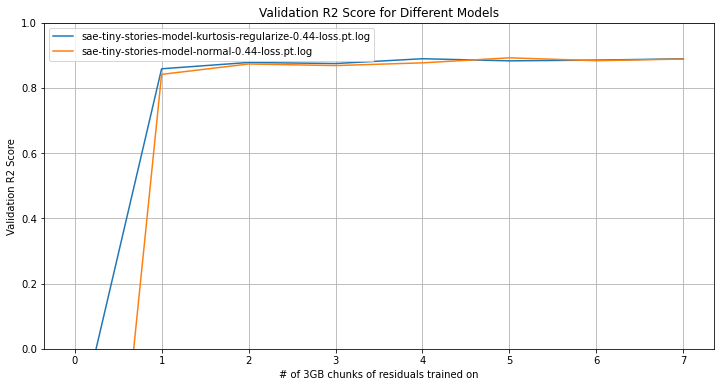

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

for key in loaded_logs.keys():
    log_data = loaded_logs[key]
    val_r2 = [entry['val_r2'] for entry in log_data]
    epochs = range(len(val_r2))
    
    plt.plot(epochs, val_r2, label=key)

plt.xlabel('# of 3GB chunks of residuals trained on')
plt.ylabel('Validation R2 Score')
plt.title('Validation R2 Score for Different Models')
plt.legend()
plt.grid(True)
plt.ylim(0, 1)  # Set y-axis range from 0 to 1
plt.show()